Functionality relating to running the whole script from terminal was commented out.

The body of the main function was moved outside for access to variables for debugging and testing.

In [2]:
"""
wscleanP.py combines the Q and U images produced by wsclean into a MFS P image and writes it to a FITS file, as well as a polarization fraction image.
If [-pathI] is provided, wscleanP will calculate a polarization fraction image

example use case, run in wd ASKAP Table 1 Data
python wscleanP.py 'sb44780/SB44780QU' 'sb44780/SB44780I-MFS-image.fits' 6 'sb44780/SB44780'


example use case, run in wd ASKAP
python wscleanP.py 'data/SB44780/imageQU/SB44780' 'data/SB44780/image/SB44780-MFS-image.fits' 72 '44780/SB44780'
"""

# constants and import
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from scipy.constants import c
from scipy.stats import multivariate_normal
from scipy.ndimage import label
import matplotlib.pyplot as plt
import numpy as np
import argparse


# # Function to parse arguments from command line
# def parse_arguments():
#     """Parse command-line arguments."""
#     parser = argparse.ArgumentParser(description="Combines the Q and U images produced by wsclean into P images.")
#     parser.add_argument("pathQU", help="If a file path to an image is 'sb44780/SB44780QU-0000-Q-image.fits' then set pathQU='sb44780/SB44780QU'")
#     parser.add_argument("pathI", help="Provide the full file path to the MFS I image FITS file'")
#     parser.add_argument("channels", type=int, help="Specify number of channels used in wsclean")
#     parser.add_argument("saveto", help="If a desired file path is 'sb44780/SB44780-MFS-P-image.fits' then set saveto='sb44780/SB44780'")
#     return parser.parse_args()


pathQU, pathI, channels, saveto = 'sb44780/SB44780QU', 'sb44780/SB44780I-MFS-image.fits', 6, 'sb44780/SB44780'
# def calculateP(pathQU, pathI, channels, saveto):

# TODO smooth Q and U images to lowest resolution before combining, see CASA command
# TODO enable refactoring in ipynb
# TODO verbose parameter to handle saving intermediate files and diagnostic plots
# WARNING running previous cells twice throws a PermissionError, suggesting FITS files are kept open. I double checked, and with fits.open should automatically be closing them.

# minimum SNR ratios for masking 
PSNR = 5
ISNR = 100 # TODO, add to parameters
antennaDiameter = 12 # m, antenna diameter for FWHM

# read in MFS-I image
with fits.open(pathI) as hdulI:
    dataI = hdulI[0].data[0,0] # Change the shape from (1,1,n,n) to (n,n)
    headerI = hdulI[0].header
degPerPix = abs(headerI['CDELT1']) # degrees per pixel of image, assuming it is same for both axes
imageLenX = headerI['NAXIS1']
imageLenY = headerI['NAXIS2']
# mask dataI values below SNR of ISNR
Imask = np.where(dataI < ISNR * dataI.std(), np.nan, 1)
dataImasked = dataI * Imask


In [3]:
# read in pol catalogue
polCat = Table.read("consolidated_catalog_ver1.2.0.fits") # TODO when adding into script, add an argument of catalog name

# Define the WCS of the image
wcs = WCS(naxis=2)
wcs.wcs.ctype = [headerI['CTYPE1'], headerI['CTYPE2']]  # Coordinate types 
wcs.wcs.crpix = [headerI['CRPIX1'], headerI['CRPIX2']]  # Reference pixel
wcs.wcs.crval = [headerI['CRVAL1']+360, headerI['CRVAL2']]  # Reference value, ra was negative, this fixes it to 0-360 range
wcs.wcs.cdelt = [headerI['CDELT1'], headerI['CDELT2']]  # Pixel scale
wcs.wcs.cunit = [headerI['CUNIT1'], headerI['CUNIT2']]  # Units

# Define the pixel coordinates of the image edges
imageRangeX = np.array([0, imageLenX]) # these might be reversed, but the image is square so it's fine
imageRangeY = np.array([0, imageLenY]) 

# Convert pixel coordinates to world coordinates (RA, Dec)
ra, dec = wcs.all_pix2world(imageRangeX, imageRangeY, 0)

# Calculate the RA and Dec bounds (deg)
ra_min, ra_max = min(ra), max(ra)
dec_min, dec_max = min(dec), max(dec)

# Filter the table
mask = ((polCat['ra'] >= ra_min) & (polCat['ra'] <= ra_max) & (polCat['dec'] >= dec_min) & (polCat['dec'] <= dec_max))
polCatMasked = polCat[mask] # 3 sources in the catalog within our image for (5, 100) SNR thresholds

# Convert RA and Dec of polarized sources to pixel coordinates
catSourceXpixs, catSourceYpixs = wcs.all_world2pix(polCatMasked['ra'], polCatMasked['dec'], 0)

# Read Stokes I, polarization intensity, polarization fraction, frequency, and rotation measure from catalog
catSourceIs = polCatMasked['stokesI']
catSourcePs = polCatMasked['polint']
catSourcePolFracs = polCatMasked['fracpol']
catSourceFreqs = np.array([(1435100000.0+1364900000.0)/2, (1435100000.0+1364900000.0)/2, 1420780900.0])/1e0 #FIXME not generalized, only 1 catalog source has an exact polarization reference frequency
catSourceRMs = polCatMasked['rm'] # units of radians per metre squared
# Catalog sources are matched to clusters by eye. This can be automated but would scale O(n^2) with catalog length.
beamCatalogPairIDs = [1,5]


In [4]:
# Initialize per channel arrays
channelPs = np.empty((channels, imageLenX, imageLenY))
channelFreqs = np.empty(channels)
channelPolAngles = np.empty((len(beamCatalogPairIDs), channels))
channelWavelengths = np.empty(channels)
channelSourceIs = np.empty((len(beamCatalogPairIDs), channels))
channelSourcePs = np.empty((len(beamCatalogPairIDs), channels))
channelSourcePfracs = np.empty((len(beamCatalogPairIDs), channels))
FWHMs = np.empty(channels) # full width half maximum, converted to degrees
PBsigmas = np.empty(channels) # primary beam response sigma 

for i in range(channels):

    # Format number to be a string literal of a 4 digit int, padded with zeros
    number = f"{i:04d}"

    # read in Q_i and copy its header, shape is (1,1,n,n)
    with fits.open(f"{pathQU}-{number}-Q-image.fits") as hdulQ:
        dataQ = hdulQ[0].data[0,0]  # Assuming the data is in the primary HDU
        headerQ = hdulQ[0].header  
        freqQ = headerQ['CRVAL3'] # Hz

    # read in U_i
    with fits.open(f"{pathQU}-{number}-U-image.fits") as hdulU:
        dataU = hdulU[0].data[0,0]  # Assuming the data is in the primary HDU

    # Ensure the two datasets have the same shape
    if dataQ.shape != dataU.shape:
        raise ValueError("The two FITS files must have the same dimensions.")
    
    # Append channel frequency, calculate channel wavelength, FWHM, and primary beam response sigma
    channelFreqs[i] = freqQ
    channelWavelengths[i] = c/freqQ
    FWHMs[i] = np.degrees(1.09 * channelWavelengths[i] / antennaDiameter) # coefficient from https://www.cambridge.org/core/services/aop-cambridge-core/content/view/S1323358020000417
    PBsigmas[i] = FWHMs[i] / 2.35482004503 # coefficient from https://brainder.org/2011/08/20/gaussian-kernels-convert-fwhm-to-sigma/

    # Produce a primary beam response image
    x = np.arange(-imageLenX // 2, imageLenX // 2)
    y = np.arange(-imageLenY // 2, imageLenY // 2)
    x, y = np.meshgrid(x, y)
    pbresponse = np.exp(-(x**2 + y**2) / (2 * (PBsigmas[i]/degPerPix)**2)) # assuming a circular gaussian
    pbresponse /= pbresponse.max() # normalize
    # hdu = fits.PrimaryHDU(pbresponse, header=headerI) 
    # hdu.writeto(f'{saveto}-{number}-pbresponse-image.fits', overwrite=True)

    # Compute stokes P square root of the sum of the squares and append to the array
    # Subtract off Riccian bias on each channel (STD and RMS are similar)
    # Correct for primary beam response
    channelP = np.sqrt(dataQ**2 + dataU**2) - np.std(dataQ)/2 - np.std(dataU)/2 # assuming uncorrected P < 4 * sigma_QU
    channelPs[i] =  channelP / pbresponse
    
    
    # identify clusters in the Stokes I image
    # labeled_array is 0 for no clusters, 1 for pixels belonging to the first cluster, 2 for pixels belonging to the 2nd cluster, etc
    labeled_array, num_clusters = label(~np.isnan(dataImasked)) # TODO only uses I mask, to use MFS P mask this would need to be moved to a second for loop


    # read in channel Stokes I image 
    # calculate Stokes I, Stokes P, polarization fraction, polarization angle for each source for each image
    with fits.open(f'{saveto}I-{number}-image.fits') as hdulChannelI: 
        dataChannelI = hdulChannelI[0].data[0,0] / pbresponse # correct for primary beam response
    # channel Stokes I have matching frequencies to Stokes Q, they are correct and not flipped
    for j, sourceID in enumerate(beamCatalogPairIDs):
        channelSourceIs[j, i] = np.max(dataChannelI[labeled_array == sourceID])
        maxIndex = np.argmax(channelP[labeled_array == sourceID])
        channelSourcePs[j, i] = np.max(channelP[labeled_array == sourceID]) 
        channelSourcePfracs[j, i] = np.max((channelP/dataImasked)[labeled_array == sourceID]) 
        channelPolAngles[j, i] = np.arctan2(dataU[labeled_array == sourceID][maxIndex], dataQ[labeled_array == sourceID][maxIndex]) / 2
    


    # Save each P_i/I image to check leakage
    # Could save P_i/I as an image cube using P_i/dataI instead but this may overwrite headers
    headerQ['CRVAL1'] += 360 # ra was negative, this fixes it to 0-360 range
    headerQ['CRVAL4'] = 4 # set the Stokes parameter to 4 (P)
    # mask values below PSNR or ISNR
    hdu = fits.PrimaryHDU(np.where(channelP < PSNR * np.std(channelP), np.nan, channelP/dataImasked), header=headerQ) 
    hdu.writeto(f'{saveto}-{number}-Pfrac-image.fits', overwrite=True)

    # Output that P_i was successfully computed and appended
    # print(f'Q_{i} MS = {Q_ms} and U_{i} MS = {U_ms} for channel {i}')
    print(f'Successfully calculated P and saved P/I to `{saveto}-{number}-Pfrac-image.fits` for channel {i}.')
    

# stack P_i into an array of shape (channels,n,n) before averaging over channels
# mask dataP values below SNR of PSNR
dataP = np.mean(np.stack(channelPs, axis=0), axis=0)
Pmask = np.where(dataI < PSNR * dataP.std(), np.nan, 1)
dataPmasked = dataP * Pmask

# DISABLED, Riccean bias is corrected at the channel level
# # Correct for Riccean bias, subtract off the average of noise from the MFS of Q and U
# with fits.open(f"{pathQU}-MFS-Q-image.fits") as hdulQMFS:
#     dataQMFS = hdulQMFS[0].data
# with fits.open(f"{pathQU}-MFS-U-image.fits") as hdulUMFS:
#     dataUMFS = hdulUMFS[0].data
# QUnoise = np.std(dataQMFS[0,0])/2 + np.std(dataUMFS[0,0])/2   # RMS and STD give similar values
# dataP[0,0] -= QUnoise

# TODO flux density off factor is almost an OoM instead of 1/2 for 44780 6 channels

# Save dataP to a new FITS file with mean channel frequency and Stokes 4
headerQ['CRVAL3'] = np.mean(channelFreqs)
hdu = fits.PrimaryHDU(dataP, header=headerQ) 
hdu.writeto(saveto+'-MFS-P-image.fits', overwrite=True)
print(f"P image saved to `{saveto}-MFS-P-image.fits`")

# Save P/I MFS to a new FITS file with mean channel frequency and Stokes 4
fracP = dataPmasked/dataImasked
hdu = fits.PrimaryHDU(fracP, header=headerQ) 
hdu.writeto(saveto+'-MFS-Pfrac-image.fits', overwrite=True)
print(f"P/I image saved to `{saveto}-MFS-Pfrac-image.fits`")

# TODO identify target and extract values from a FITS file, ideally with functionality to accept ra, dec

# DISABLED, not a useful image
# Plot masked P/I image, save, close
# plt.figure(figsize=(8, 6), facecolor='gray');
# plt.imshow(fracP, origin='lower', vmin=0, vmax=1, cmap='viridis')
# plt.colorbar(label='Polarization fraction')
# plt.title(f'Mask out pixels of P < {PSNR}*noise of P and I < {ISNR}*noise of I')
# plt.xticks([]) 
# plt.yticks([])
# plt.savefig(f'{saveto}-MFS-Pfrac-image.png', bbox_inches='tight')
# print(f"P/I image saved to `{saveto}-MFS-Pfrac-image.png`")
# plt.close()

# # Main function
# def main():
#     """Execute the script."""
#     args = parse_arguments()
#     calculateP(args.pathQU, args.pathI, args.channels, args.saveto)

# # Entry point, run the script when run from terminal
# if __name__ == "__main__":
#     main()

Successfully calculated P and saved P/I to `sb44780/SB44780-0000-Pfrac-image.fits` for channel 0.
Successfully calculated P and saved P/I to `sb44780/SB44780-0001-Pfrac-image.fits` for channel 1.
Successfully calculated P and saved P/I to `sb44780/SB44780-0002-Pfrac-image.fits` for channel 2.
Successfully calculated P and saved P/I to `sb44780/SB44780-0003-Pfrac-image.fits` for channel 3.
Successfully calculated P and saved P/I to `sb44780/SB44780-0004-Pfrac-image.fits` for channel 4.
Successfully calculated P and saved P/I to `sb44780/SB44780-0005-Pfrac-image.fits` for channel 5.
P image saved to `sb44780/SB44780-MFS-P-image.fits`
P/I image saved to `sb44780/SB44780-MFS-Pfrac-image.fits`


Decimal fraction of non nan values 1.5e-05, (0.0015%)


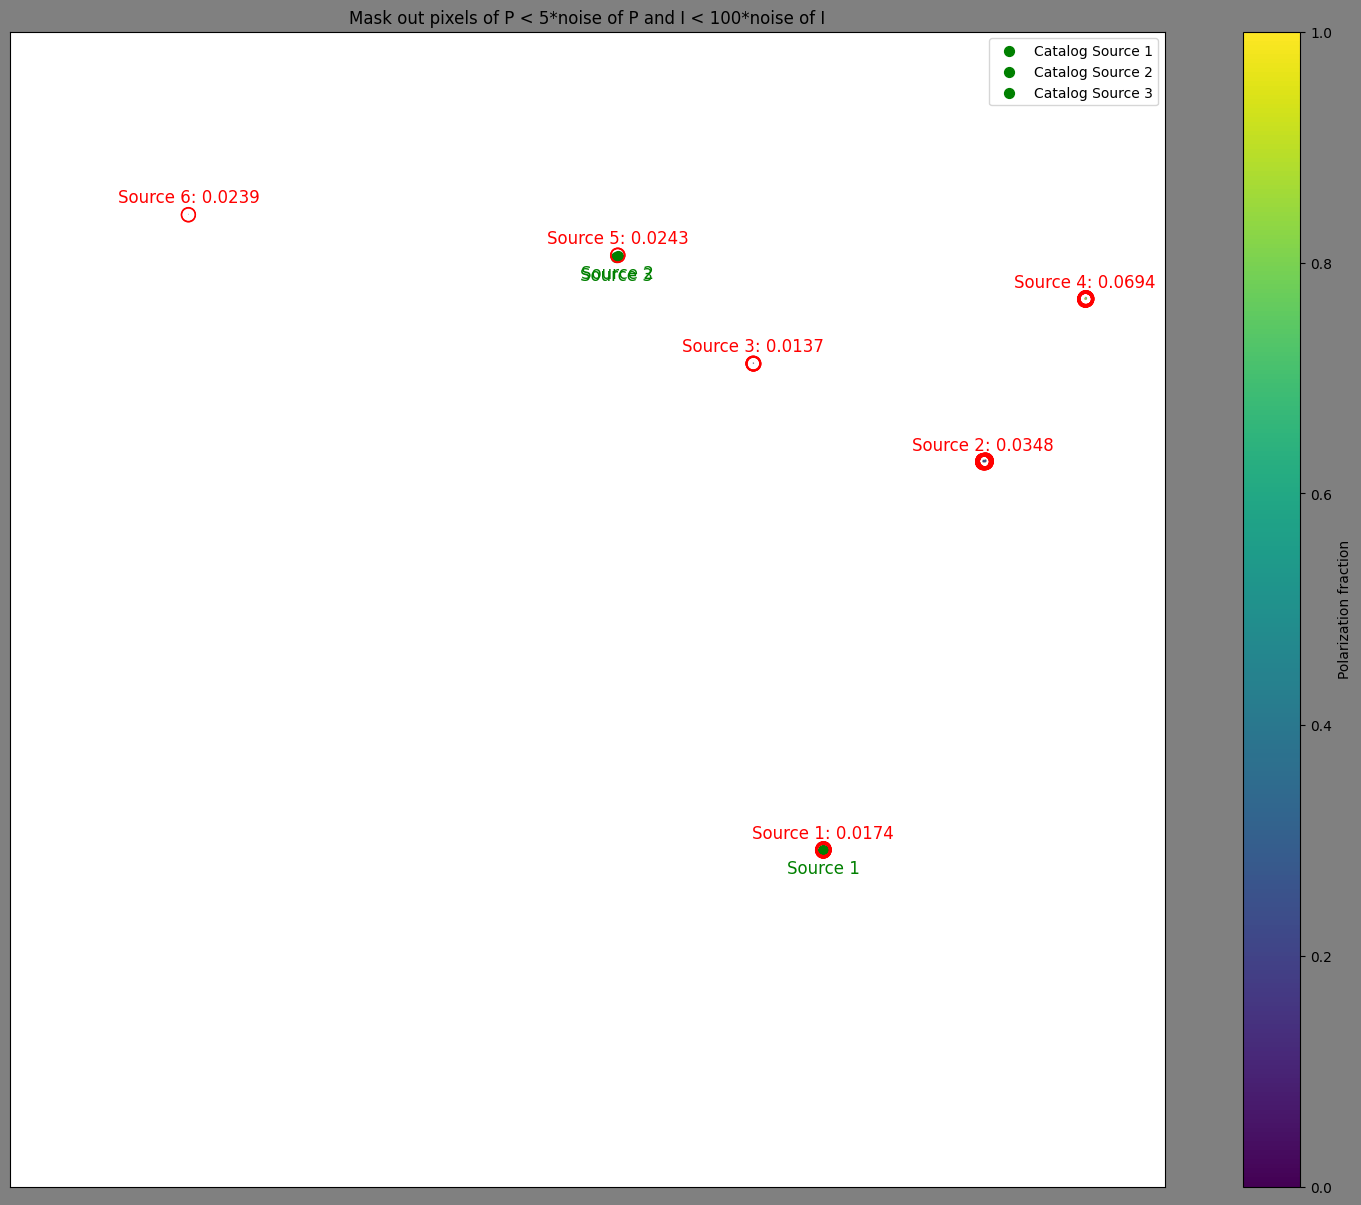

In [5]:
# Plot masked P frac and circle non masked pixels 

print(f'Decimal fraction of non nan values {np.count_nonzero(~np.isnan(fracP)) / fracP.size:.2g}, ({np.count_nonzero(~np.isnan(fracP)) / fracP.size*100:.2g}%)')

plt.figure(figsize=(20, 15), facecolor='gray')
plt.imshow(fracP, origin='lower', vmin=None, vmax=None, cmap='viridis')

for i in range (1, len(catSourceXpixs)+1):
    plt.scatter(catSourceXpixs[i-1], catSourceYpixs[i-1], color='green', s=50,  facecolors='green', label=f'Catalog Source {i}')
    plt.text(catSourceXpixs[i-1], catSourceYpixs[i-1]-50, f'Source {i}', color='green', fontsize=12, ha='center', va='center')
plt.colorbar(label='Polarization fraction')
plt.title(f'Mask out pixels of P < {PSNR}*noise of P and I < {ISNR}*noise of I')
plt.legend()
plt.xticks([])
plt.yticks([]);


# Find the max value in each cluster
for cluster_id in range(1, num_clusters + 1):
    cluster_values = fracP[labeled_array == cluster_id]
    max_value = np.nanmax(cluster_values)

    # Label each cluster on the image
    y, x = np.argwhere(labeled_array == cluster_id)[0]  # (row, col) of the first pixel of each cluster
    # Add the cluster label near the first pixel
    plt.text(x, y+50, f'Source {cluster_id}: {max_value:.4f}', color='red', fontsize=12, ha='center', va='center')
    # print(f'Cluster {cluster_id}: Max value = {max_value:.4f}')

# circle non nan values
y, x = np.where(~np.isnan(fracP))
plt.scatter(x, y, color='red', s=100, linewidth=1, facecolors='none', label='Non-NaN Pixels');

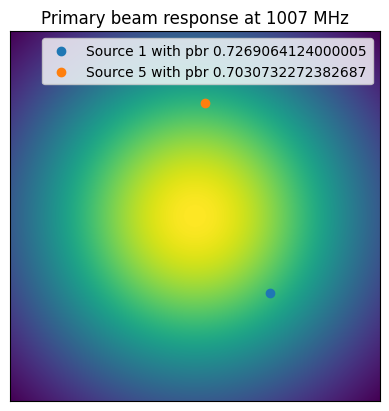

In [38]:
# Plot the final primary beam response, which has the furthest from uniform 2d gaussian
# Plot the locations of sources 
# Print the pbm response for each source
plt.imshow(pbresponse, origin='lower')
for x,y,label in zip(catSourceXpixs[:-1], catSourceYpixs[:-1], beamCatalogPairIDs):
    plt.scatter(x,y, label=f'Source {label} with pbr {pbresponse[round(x),round(y)]}')
plt.xticks([]) 
plt.yticks([])
plt.title(f'Primary beam response at {round(channelFreqs[-1]/1e6)} MHz')
plt.legend();

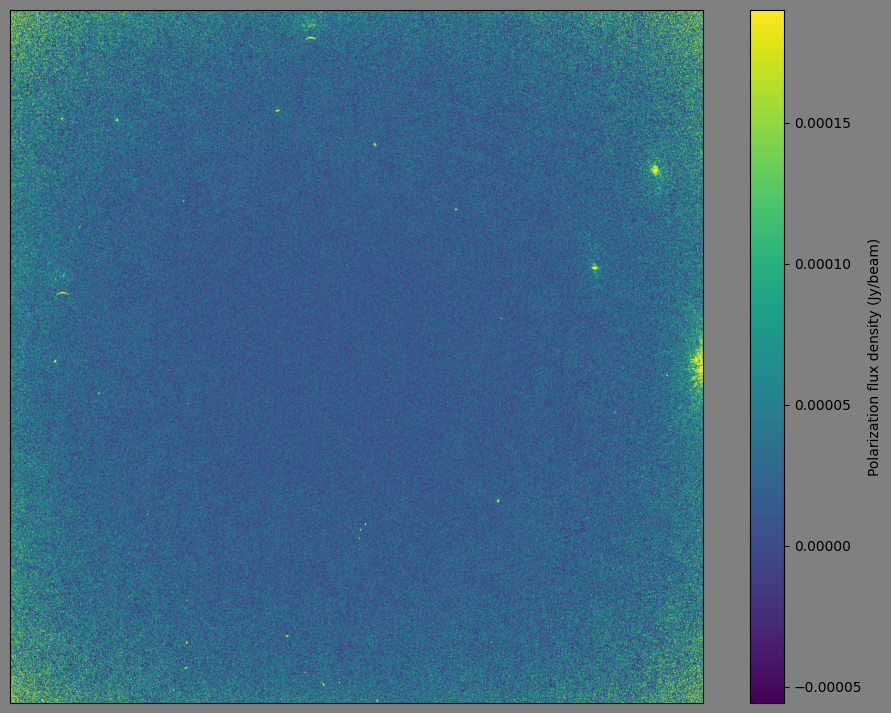

In [6]:
# Plot P flux density
from astropy.visualization import ZScaleInterval

# Get the optimal vmin and vmax using ZScaleInterval
vmin, vmax = ZScaleInterval().get_limits(dataP)

plt.figure(figsize=(12, 9), facecolor='gray');
plt.imshow(dataP, origin='lower', vmin=vmin, vmax=vmax, cmap='viridis');
plt.colorbar(label='Polarization flux density (Jy/beam)')
plt.xticks([]); 
plt.yticks([]);

In [7]:
# Plot P/I vs I for image sources and catalog sources
channelSourceIs

array([[0.14817084, 0.14053456, 0.13010532, 0.12122079, 0.11340599,
        0.10641446],
       [0.07349901, 0.07005186, 0.06479104, 0.06043245, 0.05670967,
        0.05328435]])

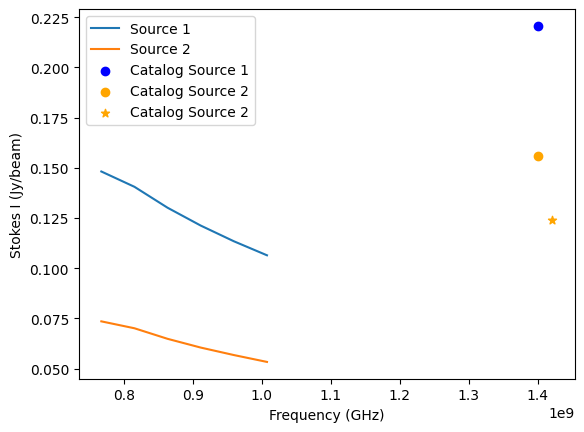

In [8]:
# Plot Stokes I over frequency for sources in field and catalog

plt.figure()
for i in range(0, len(channelSourceIs)):
    plt.plot(channelFreqs, channelSourceIs[i], label=f'Source {i+1}')  # Stokes I images produced from a different run of wsclean. Were the channels flipped somehow?

# plt.plot(channelFreqs, np.array(channelSourcePfracs).T[2], label='Source 3', ls='--')
plt.scatter(catSourceFreqs[0], catSourceIs[0],label='Catalog Source 1',color='blue')
plt.scatter(catSourceFreqs[1], catSourceIs[1],label='Catalog Source 2',color='orange')
plt.scatter(catSourceFreqs[2], catSourceIs[2],label='Catalog Source 2',marker='*',color='orange')
plt.legend()
plt.xlabel('Frequency (GHz)')
plt.ylabel('Stokes I (Jy/beam)');

In [9]:
# helper function to find peaks in a 2D array

def findPeaks(data, xCoords, yCoords, halfSize): #TODO rewrite this function to work with 2D arrays containing clusters
    """
    Find the peak value of square slices centered on given coordinates.

    Parameters:
    - data: 2D NumPy array
    - xCoords: List of x coordinates 
    - yCoords: List of y coordinates 
    - halfSize: half the side length of the square slice

    Returns:
    - List of peak values for each square slice
    """

    peakValues = []
    sourceIms = []

    for x, y in zip(xCoords, yCoords):
        sliceOfData = data[max(0, round(y) - halfSize):min(data.shape[0], round(y) + halfSize), max(0, round(x) - halfSize):min(data.shape[1], round(x) + halfSize)]
        sourceIms.append(sliceOfData)
        peakValues.append(np.nanmax(sliceOfData)) # TODO error catching for RuntimeWarning: All-NaN slice encountered

    return peakValues, sourceIms

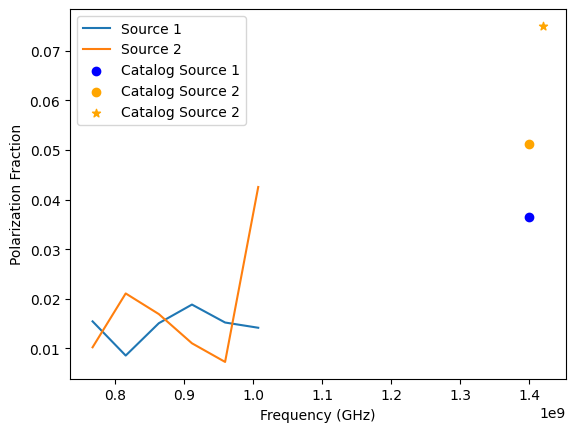

In [10]:
# Plot P/I over frequency for sources in field and catalog
# TODO plot MFS as well and then fit an exponential to find sigma_rm
# TODO ask Erik what he meant by plotting A.4 for typical sigma_rm

plt.figure()
for i in range(len(channelSourcePfracs)):
    plt.plot(channelFreqs, channelSourcePfracs[i], label=f'Source {i+1}')

plt.scatter(catSourceFreqs[0], catSourcePolFracs[0],label='Catalog Source 1',color='blue')
plt.scatter(catSourceFreqs[1], catSourcePolFracs[1],label='Catalog Source 2',color='orange')
plt.scatter(catSourceFreqs[2], catSourcePolFracs[2],label='Catalog Source 2',marker='*',color='orange')

plt.legend()
plt.xlabel('Frequency (GHz)')
plt.ylabel('Polarization Fraction');

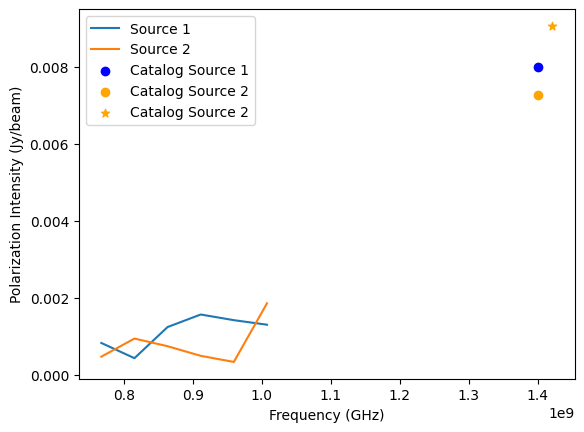

In [11]:
# Plot polarization intensity vs frequency for sources in field and catalog
# Because polarisation fraction only verifies relative flux scale of pol as ratio of total intensity, while that would verify the absolute flux scale as well
plt.figure()
for i in range(0, len(channelSourcePs)):
    plt.plot(channelFreqs, channelSourcePs[i], label=f'Source {i+1}')  # Stokes I images produced from a different run of wsclean. Were the channels flipped somehow?

# plt.plot(channelFreqs, np.array(channelSourcePfracs).T[2], label='Source 3', ls='--')
plt.scatter(catSourceFreqs[0], catSourcePs[0],label='Catalog Source 1',color='blue')
plt.scatter(catSourceFreqs[1], catSourcePs[1],label='Catalog Source 2',color='orange')
plt.scatter(catSourceFreqs[2], catSourcePs[2],label='Catalog Source 2',marker='*',color='orange')
plt.legend()
plt.xlabel('Frequency (GHz)')
plt.ylabel('Polarization Intensity (Jy/beam)');


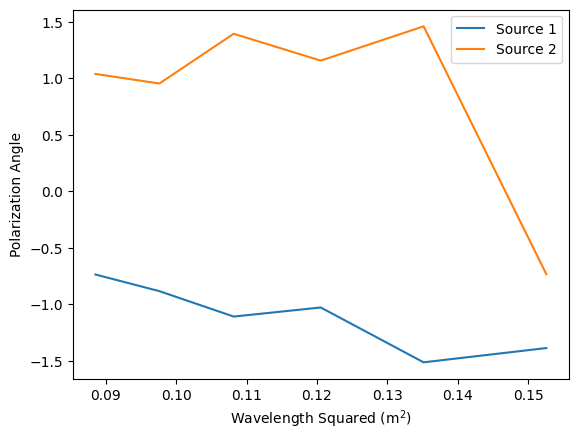

In [12]:
# plot polarization angle vs wavelength^2, as well as RM 
plt.figure()
for i in range(0, len(channelPolAngles)):
    plt.plot(channelWavelengths**2, channelPolAngles[i], label=f'Source {i+1}') 
plt.xlabel(r'Wavelength Squared (m$^2$)')
plt.ylabel('Polarization Angle')
plt.legend();

In [13]:
# used the individual maxima of Q and U at possibly different pixels

In [14]:
# plot 
# P = P0 exp (-2 * sigma_rm**2 * lambda**2)
# def 

In [15]:
#TODO install casa on device to use imsmooth

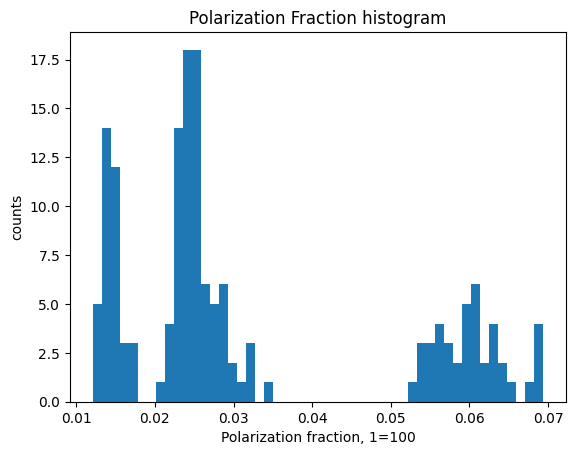

In [16]:
# plot histogram of pixels in polarization fraction image
plt.hist(fracP.flatten(),bins=50)#, range=(-.01, .05));#, alpha=0.8);
plt.title('Polarization Fraction histogram')
plt.ylabel('counts')
plt.xlabel('Polarization fraction, 1=100');